## Data Preparation

In [1]:
# import necessary modules/libraries

import numpy as  np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.7)
sns.set_palette("Greens_r")
#set_palette("Set1", 8, .75) # makes plot lines red

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn.preprocessing import Imputer # to impute missing data

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

%matplotlib inline

# read the data
df1 = pd.read_csv('house_price_prediction.csv')
df2 = df1.copy()

# change date col to datetime
df2['date'] = pd.to_datetime(df2['date'])

# change data types of 'waterfront' & 'condition' to categorical
df2[['waterfront', 'condition']] = df1[['waterfront', 'condition']].astype('category')

## Feature Engineering

In [2]:
# splittig statezip into state & zipcode features & removing statezip
df2['state'] = df2['statezip'].apply(lambda x: x.split(' ')[0])
df2['zipcode'] = df2['statezip'].apply(lambda x: int(x.split(' ')[1]))
df2 = df2.drop('statezip', axis='columns')

# creating total_sqft feature: sqft_above + sqft_lot
df2['total_sqft'] = df2.sqft_living + df2.sqft_lot

# creating month feature
df2['month'] = pd.DatetimeIndex(df2['date']).month

df3 = df2.copy()

# creating a column of boolean arrays with 1s for when price is $0 & 0s for when price is not $0
df3['price_is_zero'] = (df3['price'] == 0).astype(int)

# creating a column of boolean arrays with 1s for when yr_renov is 0 & 0s for others
df3['renov_date_is_zero'] = (df3['yr_renovated'] == 0).astype(int)

# replacing 0s with the mean bedroom & bathroom values
df3["bedrooms"].replace({0: round(df3["bedrooms"].mean(), 0)}, inplace=True)
df3["bathrooms"].replace({0: round(df3["bathrooms"].mean(), 0)}, inplace=True)

# removing price outliers
df_no_outs = df3[df3.price < 10000000].copy()

# creating a new dataframe with $0 prices removed to compare later
df_no_zeros = df_no_outs[df_no_outs["price"] != 0].copy()

## Statistical Data Analysis

In [3]:
meanprice_bedrooms = df_no_zeros.groupby('bedrooms')['price'].mean()
medianprice_bedrooms = df_no_zeros.groupby('bedrooms')['price'].median()

meansqft_bedroom = df_no_zeros.groupby("bedrooms")["sqft_living"].mean()
mediansqft_bedroom = df_no_zeros.groupby("bedrooms")["sqft_living"].median()

may_price = df_no_zeros[df_no_zeros.month==5]['price']
june_price = df_no_zeros[df_no_zeros.month==6]['price']
july_price = df_no_zeros[df_no_zeros.month==7]['price']

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)

    x = np.sort(data)

    y = np.arange(1, n+1) / n

    return x, y

# Compute ECDFs
x_5, y_5 = ecdf(may_price)
x_6, y_6 = ecdf(june_price)
x_7, y_7 = ecdf(july_price)

### Feature Importance

In [4]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

def feature_importance(X, y, model='reg'):
    score_func = {'reg': f_regression}

    # Score each of the features
    bestfeatures = SelectKBest(score_func=score_func[model], k='all')
    fit = bestfeatures.fit(X, y)

    # Organize and return the scores
    featureScores = pd.DataFrame([X.columns, fit.scores_]).T
    featureScores.columns = ['Feature', 'Score']
    return featureScores.sort_values('Score', ascending=False).set_index('Feature') 

In [5]:
X = df_no_zeros.drop(['price', 'date', 'street', 'city', 'state', 'country'], axis='columns')
y = pd.DataFrame(df_no_zeros['price'].values.reshape(-1,1))

# Data Modeling

## Data Preprocessing

In [6]:
df_no_outs = df3[df3.price < 10000000]
df_no_zeros = df_no_outs[df_no_outs["price"] != 0]

# dataframe with both zero prices and outliers.
X = df3.drop(['price', 'date', 'street', 'city', 'state', 'country'], axis='columns')
y = df3["price"]
# splitting data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# dataframe without price outliers
X_no_outs = df_no_outs.drop(['price', 'date', 'street', 'city', 'state', 'country'], axis='columns')
y_no_outs = df_no_outs["price"]
X_train_no_outs, X_test_no_outs, y_train_no_outs, y_test_no_outs = train_test_split(X_no_outs, y_no_outs, test_size = 0.3, random_state=42)

# dataframe without $0 price values
X_no_zeros = df_no_zeros.drop(['price', 'date', 'street', 'city', 'state', 'country'], axis='columns')
y_no_zeros = df_no_zeros["price"]
X_train_no_zeros, X_test_no_zeros, y_train_no_zeros, y_test_no_zeros = train_test_split(X_no_zeros, y_no_zeros, test_size = 0.3, random_state=42)

# dataframe with a parabolic transformation on the `bedrooms` feature
X_transformed = df_no_zeros.drop(['price', 'date', 'street', 'city', 'state', 'country'], axis='columns')
X_transformed['bedrooms_squared'] = X['bedrooms']**2  # parabolic transformation of bedrooms
y_transformed = df_no_zeros['price']
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(X_transformed, y_transformed, test_size = 0.3, random_state=42)

In [7]:
set1 = [X_train, X_test, y_train, y_test]
set2 = [X_train_no_outs, X_test_no_outs, y_train_no_outs, y_test_no_outs]
set3 = [X_train_no_zeros, X_test_no_zeros, y_train_no_zeros, y_test_no_zeros]
set4 = [X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed]

sets = [set1, set2, set3, set4]

algorithms = [LinearRegression, Ridge, RandomForestRegressor]
names = ['linear regression', 'ridge regression ', 'random forest    ']

In [8]:
linear_score = []
ridge_score = []
forest_score = []

for sets in sets:
    # linear regression
    model = algorithms[0]()
    model.fit(sets[0], sets[2])
    y_pred = model.predict(sets[1])
    
    training_score = model.score(sets[0], sets[2])
    test_score = model.score(sets[1], sets[3])
    rmse = np.sqrt(mean_squared_error(sets[3], y_pred))
    
    print(names[0], "R^2: {}, RMSE: {}".format(test_score, rmse))
    linear_score.append(test_score)
    
    # ridge regression
    
    model = algorithms[1]()
    model.fit(sets[0], sets[2])
    y_pred = model.predict(sets[1])
    
    training_score = model.score(sets[0], sets[2])
    test_score = model.score(sets[1], sets[3])
    rmse = np.sqrt(mean_squared_error(sets[3], y_pred))
    
    print(names[1], "R^2: {}, RMSE: {}".format(test_score, rmse))
    
    ridge_score.append(test_score)
    
    # random forest
    
    model = algorithms[2]()
    model.fit(sets[0], sets[2])
    y_pred = model.predict(sets[1])
    
    training_score = model.score(sets[0], sets[2])
    test_score = model.score(sets[1], sets[3])
    rmse = np.sqrt(mean_squared_error(sets[3], y_pred))
    
    print(names[2], "R^2: {}, RMSE: {}".format(test_score, rmse))
    
    forest_score.append(test_score)

linear regression R^2: 0.0677794837057436, RMSE: 820661.0513756288
ridge regression  R^2: 0.06782834917275116, RMSE: 820639.5422421335
random forest     R^2: 0.07006318137905321, RMSE: 819655.2319912887
linear regression R^2: 0.5653871573329925, RMSE: 242953.0558186268
ridge regression  R^2: 0.5656890507214902, RMSE: 242868.6604033432
random forest     R^2: 0.5898482338599351, RMSE: 236017.05185587358
linear regression R^2: 0.5953517302538858, RMSE: 236687.2794862909
ridge regression  R^2: 0.5953049326209416, RMSE: 236700.96555024775
random forest     R^2: 0.6210883794242805, RMSE: 229036.6781655698
linear regression R^2: 0.595484911092392, RMSE: 236648.32614478978
ridge regression  R^2: 0.5954292749675731, RMSE: 236664.5996330863
random forest     R^2: 0.619698446669084, RMSE: 229456.37257099783


In [9]:
features1 = 'all except date, price, street, city, state'
features2 = 'all except date, price, street, city, state'
features3 = 'all except date, price, street, city, state'
features4 = 'all except date, price, street, city, state'
features5 = 'all except date, price, street, city, state'
features6 = 'all except date, price, street, city, state'
features7 = 'all except date, price, street, city, state'
features8 = 'all except date, price, street, city, state'
features9 = 'all except date, price, street, city, state'
features10 = 'all except date, price, street, city, state'
features11 = 'all except date, price, street, city, state'
features12 = 'all except date, price, street, city, state'

content = {'features': [features1, features2, features3, features4, features5, features6, 
                        features7, features8, features9, features10, features11, features12], 
           'model': ['linear regression', 'linear regression', 'linear regression', 'linear regression',
                     'ridge regression', 'ridge regression', 'ridge regression', 'ridge regression', 
                     'random forest', 'random forest', 'random forest', 'random forest'], 
           'score': [linear_score[0], linear_score[1], linear_score[2], linear_score[3], 
                     ridge_score[0], ridge_score[1], ridge_score[2], ridge_score[3],  
                     forest_score[0], forest_score[1], forest_score[2], forest_score[3]],
           'description': ['no transformations', 'no transformations', 'zero prices removed', 'parabolic transformation', 
                           'no transformations', 'no transformations', 'zero prices removed', 'parabolic transformation', 
                           'no transformations', 'no transformations', 'zero prices removed', 'parabolic transformation'],
           'price outs removed': ['no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'yes', 'yes']}

table = pd.DataFrame(content, columns=['model', 'score', 'price outs removed', 'description', 'features'], index=[1,2,3,4,5,6,7,8,9,10,11,12])
table.sort_values('score', ascending=False)

,model,score,price outs removed,description,features
11,random forest,0.621088,yes,zero prices removed,"all except date, price, street, city, state"
12,random forest,0.619698,yes,parabolic transformation,"all except date, price, street, city, state"
4,linear regression,0.595485,yes,parabolic transformation,"all except date, price, street, city, state"
8,ridge regression,0.595429,yes,parabolic transformation,"all except date, price, street, city, state"
3,linear regression,0.595352,yes,zero prices removed,"all except date, price, street, city, state"
7,ridge regression,0.595305,yes,zero prices removed,"all except date, price, street, city, state"
10,random forest,0.589848,yes,no transformations,"all except date, price, street, city, state"
6,ridge regression,0.565689,yes,no transformations,"all except date, price, street, city, state"
2,linear regression,0.565387,yes,no transformations,"all except date, price, street, city, state"
9,random forest,0.070063,no,no transformations,"all except date, price, street, city, state"


We can see that the best regressor is the Random Forest, with 62% accuracy. It makes sense that the data frame with price outliers and zeros removed had the best performing model.

Text(0, 0.5, 'actual price')

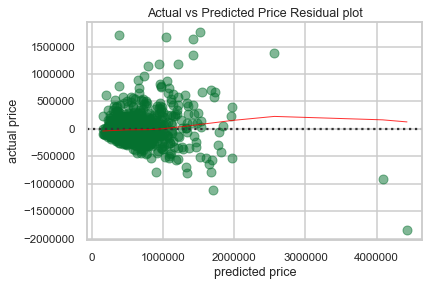

In [10]:
actual_price = y_test_transformed
predicted_price = y_pred

sns.residplot(predicted_price, actual_price, data=df_no_zeros,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plt.title('Actual vs Predicted Price Residual plot')
plt.xlabel('predicted price')
plt.ylabel('actual price')